In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers

## PART_I: K-means Algorithm

In [132]:
hotel_info = pd.read_csv("Cleaned_Booking_Hotel_Updated.csv")

NY_hotel_info = hotel_info[hotel_info['City'] == 'New_York']
Chicago_hotel_info = hotel_info[hotel_info['City'] == 'Chicago']
LA_hotel_info = hotel_info[hotel_info['City'] == 'Los_Angeles']

NY_hotel_info_new = NY_hotel_info.drop(columns=['_id', 'address', 'label', 'name', 'City', 'Room_type'])
Chicago_hotel_info_new = Chicago_hotel_info.drop(columns=['_id', 'address', 'label', 'name', 'City', 'Room_type'])
LA_hotel_info_new = LA_hotel_info.drop(columns=['_id', 'address', 'label', 'name', 'City', 'Room_type'])

scaler = RobustScaler()
NY_hotel_info_new = scaler.fit_transform(NY_hotel_info_new)
Chicago_hotel_info_new = scaler.fit_transform(Chicago_hotel_info_new)
LA_hotel_info_new = scaler.fit_transform(LA_hotel_info_new)

NY_hotel_info_new = pd.DataFrame(NY_hotel_info_new)
Chicago_hotel_info_new = pd.DataFrame(Chicago_hotel_info_new)
LA_hotel_info_new = pd.DataFrame(LA_hotel_info_new)

print(hotel_info.shape)
print(NY_hotel_info_new.shape)
print(Chicago_hotel_info_new.shape)
print(LA_hotel_info_new.shape)

(641, 14)
(290, 8)
(137, 8)
(214, 8)


### New_York:

In [133]:
#: Data processing

n_rows = len(NY_hotel_info_new)
n_rows_90_percent = int(n_rows * 0.9)
NY_hotel_info = NY_hotel_info.reset_index()
NY_hotel_info_new['name'] = NY_hotel_info['name']
NY_hotel_info_new = NY_hotel_info_new.sample(frac = 1, random_state = 935)
train_NY_hotel_info_pre = NY_hotel_info_new.iloc[:n_rows_90_percent]
test_NY_hotel_info_pre = NY_hotel_info_new.iloc[n_rows_90_percent:]

train_NY_hotel_info = train_NY_hotel_info_pre.drop(columns = ['name'])
test_NY_hotel_info = test_NY_hotel_info_pre.drop(columns = ['name'])

train_NY_hotel_info = train_NY_hotel_info.reset_index()
test_NY_hotel_info = test_NY_hotel_info.reset_index()

train_NY_hotel_info = train_NY_hotel_info.drop(columns=['index'])
test_NY_hotel_info = test_NY_hotel_info.drop(columns=['index'])

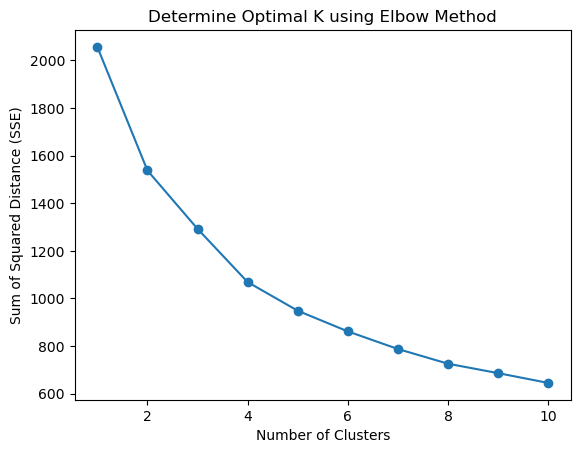

,SSE_1,SSE_2,SSE_diff
0,2056.727030,1537.842425,518.884605
1,1537.842425,1292.671623,245.170802
2,1292.671623,1069.005655,223.665968
3,1069.005655,948.584226,120.421429
4,948.584226,861.823803,86.760423
5,861.823803,787.811904,74.011899
6,787.811904,726.068332,61.743571
7,726.068332,686.484078,39.584255
8,686.484078,645.391644,41.092434


In [134]:
#: Determine the optimal K

SSE = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 936)
    kmeans.fit(train_NY_hotel_info)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, '-o')
plt.title('Determine Optimal K using Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance (SSE)')
plt.show()

SSE_1 = SSE[:-1]
SSE_2 = SSE[1:]
temp_data = {'SSE_1':SSE_1, 'SSE_2':SSE_2}
temp_data = pd.DataFrame(temp_data)
temp_data['SSE_diff'] = temp_data['SSE_1'] - temp_data['SSE_2']
temp_data #: We conclude the optimal k equals 2 based on the elbow method

In [135]:
#: Model fitting

kmeans_2 = KMeans(n_clusters = 2)
kmeans_2.fit(train_NY_hotel_info)
initial_sse = kmeans_2.inertia_
initial_sample_size = len(train_NY_hotel_info)
NY_cluster_labels = kmeans_2.labels_
train_NY_hotel_info['labels'] = NY_cluster_labels
train_NY_hotel_info['name'] = train_NY_hotel_info_pre['name']

print(initial_sse)
print(initial_sample_size)

1537.8424251015124
261


In [136]:
#: Model validation

test_NY_hotel_info = np.array(test_NY_hotel_info)
train_NY_hotel_info = train_NY_hotel_info.drop(columns=['labels', 'name'])
train_NY_hotel_info = np.array(train_NY_hotel_info)

for i in range(len(test_NY_hotel_info)):
    row_to_add = test_NY_hotel_info[i, :]
    test_data = np.delete(test_NY_hotel_info, i, axis = 0)
    train_data = np.concatenate((train_NY_hotel_info, row_to_add.reshape(1,-1)), axis=0)
    kmeans_2.fit(train_data)
    new_sse = kmeans_2.inertia_
    percent_increase_sse = (new_sse - initial_sse)/ initial_sse * 100
    percent_increase_sample = (i+1)/ initial_sample_size * 100
    print(percent_increase_sse, percent_increase_sample, ' ', sep="\n")

0.2506192151283156
0.38314176245210724
 
0.18845941291449056
0.7662835249042145
 
0.20017922598970034
1.1494252873563218
 
0.2521788908969052
1.532567049808429
 
0.463045323031907
1.9157088122605364
 
0.8244044067269702
2.2988505747126435
 
0.14867275232727012
2.681992337164751
 
0.2866149986506425
3.065134099616858
 
1.4848632349874993
3.4482758620689653
 
0.15773881900059147
3.8314176245210727
 
0.37813989273939114
4.21455938697318
 
0.043999697330119304
4.597701149425287
 
0.46845054673096975
4.980842911877394
 
0.6590150689299933
5.363984674329502
 
0.1875730704970733
5.747126436781609
 
0.37414893312851943
6.130268199233716
 
1.109475597126453
6.513409961685824
 
0.6660873067694248
6.896551724137931
 
0.08891443783708423
7.2796934865900385
 
0.09969256413323618
7.662835249042145
 
0.37213773279115414
8.045977011494253
 
0.21714906452213234
8.42911877394636
 
0.2509557756545437
8.812260536398467
 
1.2108540236793728
9.195402298850574
 
0.355291165080427
9.578544061302683
 
0.128807

In [138]:
#: Now fit the entire data set using K-mean algorithm

NY_hotel_info_new['name'] = NY_hotel_info['name']
NY_hotel_info_new = NY_hotel_info_new.sample(frac = 1, random_state = 937)

name_column = NY_hotel_info_new['name']

NY_hotel_info_new = NY_hotel_info_new.drop(columns = ['name'])
kmeans_2.fit(NY_hotel_info_new)
NY_final_labels = kmeans_2.labels_
NY_hotel_info_new['name'] = NY_hotel_info['name']
NY_hotel_info_new['labels'] = NY_final_labels

competition_poor_1 = NY_hotel_info_new.loc[NY_hotel_info_new['labels'] == 1, 'name']
competition_poor_2 = NY_hotel_info_new.loc[NY_hotel_info_new['labels'] == 0, 'name']

competition_poor_1 = pd.DataFrame(competition_poor_1)
competition_poor_2 =pd.DataFrame(competition_poor_2)

competition_poor_1.to_csv('/Users/yifan_zhu/Desktop/NY_competition_poor_1.csv', index=False)
competition_poor_2.to_csv('/Users/yifan_zhu/Desktop/NY_competition_poor_2.csv', index=False)

### Chicago:

In [143]:
#: Data processing

n_rows = len(Chicago_hotel_info_new)
n_rows_90_percent = int(n_rows * 0.9)
Chicago_hotel_info = Chicago_hotel_info.reset_index()
Chicago_hotel_info_new['name'] = Chicago_hotel_info['name']
Chicago_hotel_info_new = Chicago_hotel_info_new.sample(frac = 1, random_state = 938)
train_Chicago_hotel_info_pre = Chicago_hotel_info_new.iloc[:n_rows_90_percent]
test_Chicago_hotel_info_pre = Chicago_hotel_info_new.iloc[n_rows_90_percent:]

train_Chicago_hotel_info = train_Chicago_hotel_info_pre.drop(columns = ['name'])
test_Chicago_hotel_info = test_Chicago_hotel_info_pre.drop(columns = ['name'])

train_Chicago_hotel_info = train_Chicago_hotel_info.reset_index()
test_Chicago_hotel_info = test_Chicago_hotel_info.reset_index()

train_Chicago_hotel_info = train_Chicago_hotel_info.drop(columns=['index'])
test_Chicago_hotel_info = test_Chicago_hotel_info.drop(columns=['index'])

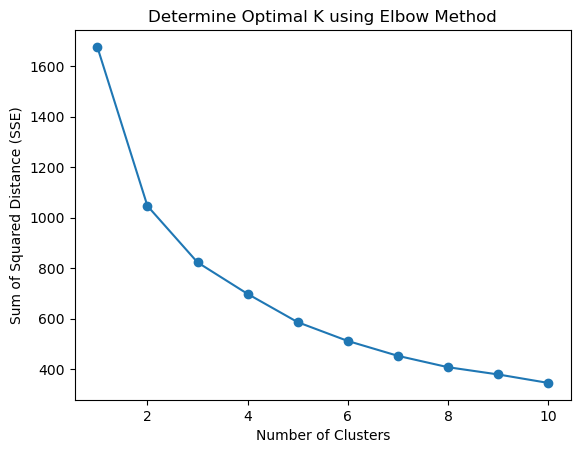

,SSE_1,SSE_2,SSE_diff
0,1675.231404,1046.278694,628.952710
1,1046.278694,822.959583,223.319111
2,822.959583,698.178756,124.780828
3,698.178756,586.359425,111.819331
4,586.359425,512.035129,74.324296
5,512.035129,453.206421,58.828708
6,453.206421,408.276084,44.930337
7,408.276084,379.649930,28.626154
8,379.649930,346.124583,33.525347


In [144]:
#: Determine the optimal K

SSE = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 939)
    kmeans.fit(train_Chicago_hotel_info)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, '-o')
plt.title('Determine Optimal K using Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance (SSE)')
plt.show()

SSE_1 = SSE[:-1]
SSE_2 = SSE[1:]
temp_data = {'SSE_1':SSE_1, 'SSE_2':SSE_2}
temp_data = pd.DataFrame(temp_data)
temp_data['SSE_diff'] = temp_data['SSE_1'] - temp_data['SSE_2']
temp_data #: We conclude the optimal k equals 2 based on the elbow method

In [145]:
#: Model fitting

kmeans_2 = KMeans(n_clusters = 2)
kmeans_2.fit(train_Chicago_hotel_info)
initial_sse = kmeans_2.inertia_
initial_sample_size = len(train_Chicago_hotel_info)
Chicago_cluster_labels = kmeans_2.labels_
train_Chicago_hotel_info['labels'] = Chicago_cluster_labels
train_Chicago_hotel_info['name'] = train_Chicago_hotel_info_pre['name']

print(initial_sse)
print(initial_sample_size)

1046.2786941143886
123


In [146]:
#: Model validation

test_Chicago_hotel_info = np.array(test_Chicago_hotel_info)
train_Chicago_hotel_info = train_Chicago_hotel_info.drop(columns=['labels', 'name'])
train_Chicago_hotel_info = np.array(train_Chicago_hotel_info)

for i in range(len(test_Chicago_hotel_info)):
    row_to_add = test_Chicago_hotel_info[i, :]
    test_data = np.delete(test_Chicago_hotel_info, i, axis = 0)
    train_data = np.concatenate((train_Chicago_hotel_info, row_to_add.reshape(1,-1)), axis=0)
    kmeans_2.fit(train_data)
    new_sse = kmeans_2.inertia_
    percent_increase_sse = (new_sse - initial_sse)/ initial_sse * 100
    percent_increase_sample = (i+1)/ initial_sample_size * 100
    print(percent_increase_sse, percent_increase_sample, ' ', sep="\n")

0.492110802084848
0.8130081300813009
 
1.49620491875007
1.6260162601626018
 
2.9886221369701658
2.4390243902439024
 
0.889448975451625
3.2520325203252036
 
0.2226316200166716
4.0650406504065035
 
0.2810775899799301
4.878048780487805
 
0.323664697356175
5.691056910569105
 
7.8067375232141
6.504065040650407
 
0.6486266527346579
7.317073170731707
 
0.3460204615442937
8.130081300813007
 
0.24247341534231293
8.94308943089431
 
0.3756212295865612
9.75609756097561
 
1.01351546992105
10.569105691056912
 
0.879954938703378
11.38211382113821
 


In [147]:
#: Now fit the entire data set using K-mean algorithm

Chicago_hotel_info_new['name'] = Chicago_hotel_info['name']
Chicago_hotel_info_new = Chicago_hotel_info_new.sample(frac = 1, random_state = 939)

name_column = Chicago_hotel_info_new['name']

Chicago_hotel_info_new = Chicago_hotel_info_new.drop(columns = ['name'])
kmeans_2.fit(Chicago_hotel_info_new)
Chicago_final_labels = kmeans_2.labels_
Chicago_hotel_info_new['name'] = Chicago_hotel_info['name']
Chicago_hotel_info_new['labels'] = Chicago_final_labels

competition_poor_1 = Chicago_hotel_info_new.loc[Chicago_hotel_info_new['labels'] == 1, 'name']
competition_poor_2 = Chicago_hotel_info_new.loc[Chicago_hotel_info_new['labels'] == 0, 'name']

competition_poor_1 = pd.DataFrame(competition_poor_1)
competition_poor_2 =pd.DataFrame(competition_poor_2)

competition_poor_1.to_csv('/Users/yifan_zhu/Desktop/Chicago_competition_poor_1.csv', index=False)
competition_poor_2.to_csv('/Users/yifan_zhu/Desktop/Chicago_competition_poor_2.csv', index=False)

### Los Angeles:

In [149]:
#: Data processing

n_rows = len(LA_hotel_info_new)
n_rows_90_percent = int(n_rows * 0.9)
LA_hotel_info = LA_hotel_info.reset_index()
LA_hotel_info_new['name'] = LA_hotel_info['name']
LA_hotel_info_new = LA_hotel_info_new.sample(frac = 1, random_state = 940)
train_LA_hotel_info_pre = LA_hotel_info_new.iloc[:n_rows_90_percent]
test_LA_hotel_info_pre = LA_hotel_info_new.iloc[n_rows_90_percent:]

train_LA_hotel_info = train_LA_hotel_info_pre.drop(columns = ['name'])
test_LA_hotel_info = test_LA_hotel_info_pre.drop(columns = ['name'])

train_LA_hotel_info = train_LA_hotel_info.reset_index()
test_LA_hotel_info = test_LA_hotel_info.reset_index()

train_LA_hotel_info = train_LA_hotel_info.drop(columns=['index'])
test_LA_hotel_info = test_LA_hotel_info.drop(columns=['index'])

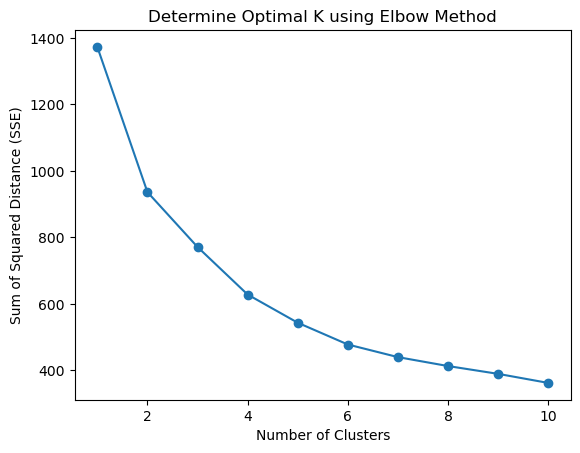

,SSE_1,SSE_2,SSE_diff
0,1372.881102,936.373110,436.507991
1,936.373110,771.322335,165.050776
2,771.322335,628.317685,143.004650
3,628.317685,543.579688,84.737997
4,543.579688,478.087213,65.492475
5,478.087213,440.174963,37.912250
6,440.174963,413.316936,26.858027
7,413.316936,389.816009,23.500927
8,389.816009,362.581924,27.234085


In [150]:
#: Determine the optimal K

SSE = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 939)
    kmeans.fit(train_LA_hotel_info)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, '-o')
plt.title('Determine Optimal K using Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance (SSE)')
plt.show()

SSE_1 = SSE[:-1]
SSE_2 = SSE[1:]
temp_data = {'SSE_1':SSE_1, 'SSE_2':SSE_2}
temp_data = pd.DataFrame(temp_data)
temp_data['SSE_diff'] = temp_data['SSE_1'] - temp_data['SSE_2']
temp_data #: We conclude the optimal k equals 2 based on the elbow method

In [151]:
#: Model fitting

kmeans_2 = KMeans(n_clusters = 2)
kmeans_2.fit(train_LA_hotel_info)
initial_sse = kmeans_2.inertia_
initial_sample_size = len(train_LA_hotel_info)
LA_cluster_labels = kmeans_2.labels_
train_LA_hotel_info['labels'] = LA_cluster_labels
train_LA_hotel_info['name'] = train_LA_hotel_info_pre['name']

print(initial_sse)
print(initial_sample_size)

936.373110376536
192


In [152]:
#: Model validation

test_LA_hotel_info = np.array(test_LA_hotel_info)
train_LA_hotel_info = train_LA_hotel_info.drop(columns=['labels', 'name'])
train_LA_hotel_info = np.array(train_LA_hotel_info)

for i in range(len(test_LA_hotel_info)):
    row_to_add = test_LA_hotel_info[i, :]
    test_data = np.delete(test_LA_hotel_info, i, axis = 0)
    train_data = np.concatenate((train_LA_hotel_info, row_to_add.reshape(1,-1)), axis=0)
    kmeans_2.fit(train_data)
    new_sse = kmeans_2.inertia_
    percent_increase_sse = (new_sse - initial_sse)/ initial_sse * 100
    percent_increase_sample = (i+1)/ initial_sample_size * 100
    print(percent_increase_sse, percent_increase_sample, ' ', sep="\n")

0.3293202582521241
0.5208333333333333
 
1.1072203415886681
1.0416666666666665
 
0.2889254382889347
1.5625
 
1.2164566549958378
2.083333333333333
 
0.3375195013658638
2.604166666666667
 
0.3840451693826577
3.125
 
0.40406558615737914
3.6458333333333335
 
0.9226222609613625
4.166666666666666
 
0.28887084032301347
4.6875
 
0.4398742779473902
5.208333333333334
 
0.5458004970087155
5.729166666666666
 
0.3388344771894751
6.25
 
0.2061822176474946
6.770833333333333
 
0.2287888942384841
7.291666666666667
 
0.30442417870218447
7.8125
 
0.43487408049794185
8.333333333333332
 
0.3673753424450541
8.854166666666668
 
0.4864765083668952
9.375
 
0.4447304795224586
9.895833333333332
 
0.16231760179929616
10.416666666666668
 
0.14404400616237456
10.9375
 
0.27312897172021694
11.458333333333332
 


In [153]:
#: Now fit the entire data set using K-mean algorithm

LA_hotel_info_new['name'] = LA_hotel_info['name']
LA_hotel_info_new = LA_hotel_info_new.sample(frac = 1, random_state = 939)

name_column = LA_hotel_info_new['name']

LA_hotel_info_new = LA_hotel_info_new.drop(columns = ['name'])
kmeans_2.fit(LA_hotel_info_new)
LA_final_labels = kmeans_2.labels_
LA_hotel_info_new['name'] = LA_hotel_info['name']
LA_hotel_info_new['labels'] = LA_final_labels

competition_poor_1 = LA_hotel_info_new.loc[LA_hotel_info_new['labels'] == 1, 'name']
competition_poor_2 = LA_hotel_info_new.loc[LA_hotel_info_new['labels'] == 0, 'name']

competition_poor_1 = pd.DataFrame(competition_poor_1)
competition_poor_2 =pd.DataFrame(competition_poor_2)

competition_poor_1.to_csv('/Users/yifan_zhu/Desktop/LA_competition_poor_1.csv', index=False)
competition_poor_2.to_csv('/Users/yifan_zhu/Desktop/LA_competition_poor_2.csv', index=False)

## PART_II: CART & Random Forest Algorithm

In [ ]:
#reading the dataset
hotel_df = pd.read_csv('/Users/akhilmohan/Downloads/Cleaned_Hotel_Info_Updated.csv')
hotel_df.info()

In [ ]:
# Remove the irrelevant columns from the dataset
cols_to_remove = ['_id', 'name', 'address','label']
hotel_df = hotel_df.drop(cols_to_remove, axis=1)

In [ ]:
#To make this price predictor, let's grow a CART tree
#We want to include 'City' and 'Room Type' as part of our decision tree, because they are important factors that may affect the price
#Let's use one hot encoding to encode these two variables.
# extract categorical variables
cat_vars = ['City','Room_type']

In [ ]:
# one-hot encode categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(hotel_df[cat_vars])
onehot = enc.transform(hotel_df[cat_vars]).toarray()

In [ ]:
# concatenate one-hot encoded variables with numerical variables

hotel_df = pd.concat([hotel_df, pd.DataFrame(onehot)], axis=1)

#We want to highlight that since our categorical variables are not ordinal (NY/Chicago/LA do not represent ordered data), we may get arbitrary splits in our decision trees.

In [ ]:
X = hotel_df.drop(['price','City','Room_type'], axis=1)
X.columns = X.columns.astype(str)
Y = hotel_df['price']
print(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Fit the CART Tree model on the training data
cart_model = DecisionTreeRegressor(random_state=42)
cart_model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = cart_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error (CART Tree):", mse)
print("R-squared value (CART Tree) on test data (Out of Sample Rsq):", r2)


# The CART model provided an MSE of 10487 and an out of sample Rsq of 17.9%. Clearly , it is not a great model at predicting the price as it is not able to generalize well to the new data and has poor performance on the test set.

In [ ]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(cart_model, feature_names=X.columns, filled=True)
plt.show()

In [ ]:
# Fit the XGBoost model on the training data
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error (XGBoost):", mse)

r2 = r2_score(y_test, y_pred)
print("R-squared (XGBoost):", r2)


rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root mean squared error (XGBoost):", rmse)


# Calculate and print feature importances
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)
print("Feature importances:\n", feat_imp)


# The model using Boosting (XGBoost) gives an MSE of 12458 and an out of sample Rsq of just 2.5%

In [ ]:
# Fit the Random Forest model on the training data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error (Random Forest):", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared (Random Forest):", r2)


# The Random forest provided a much smaller MSE (6341) and better out of sample Rsq (50%), clearly indicating that the ensemble method is better at predicting the price of the Hotel rooms.


In [ ]:
#Fit the data on a neural network

# Define the model architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
loss, mse, mae = model.evaluate(X_test, y_test)
print("Mean squared error (Neural Network):", mse)
r2 = r2_score(y_test, model.predict(X_test))
print("R-squared (Neural Network):", r2)


# The neural network provides an MSE of 10013 and an out of sample Rsq of 21.6%. It is performing better than the CART and Boosted Trees, but not better than the Random Forest.


In [ ]:
#Fit the data on a neural network

# Define the model architecture
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing data
loss, mse, mae = model.evaluate(X_test, y_test)
print("Mean squared error (Neural Network):", mse)
r2 = r2_score(y_test, model.predict(X_test))
print("R-squared (Neural Network):", r2)


# Thus,considering the MSE and the out of sample Rsq, the final model for price prediction should be Random Forest.